# Paradigm 04: Quality Gates Research Agent

This notebook implements the **Industrial Control Theory (Quality Gates)** paradigm from the Research Paradigms document.

## Core Concept

Quality gates act as checkpoints between research phases, enforcing quality criteria before proceeding:
- **Post-Search Gate**: Validates source quantity and diversity
- **Post-Synthesis Gate**: Validates claim coverage and evidence support
- **Retry Logic**: Modifies queries on gate failure

## Literature Validation

> "Quality gates for research validation have emerged as a key architectural pattern in AI Scientist and Agent Laboratory... demonstrating the effectiveness of staged quality checkpoints." —Feasibility Report

## Technology Stack

- **LLM**: `gpt-5-mini-2025-08-07`
- **Web Search**: Tavily API
- **Tracing**: LangSmith
- **Framework**: LangGraph

## 1. Setup and Configuration

In [1]:
import os
import operator
import asyncio
import re
from pathlib import Path
from typing import List, Annotated, TypedDict, Literal
from collections import Counter

from dotenv import load_dotenv
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from tavily import TavilyClient

from langgraph.graph import StateGraph, START, END

# Load environment variables
env_path = Path("../.env")
load_dotenv(env_path)

# Configure LangSmith tracing
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "deep_research_new"

print("Environment configured successfully")

Environment configured successfully


In [2]:
# Initialize LLM and Tavily client
MODEL_NAME = "gpt-5-mini-2025-08-07"
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
tavily_client = TavilyClient()

# Quality Gate Configuration
MIN_SOURCES = 5  # Minimum sources required to pass Gate 1
MIN_DOMAIN_DIVERSITY = 3  # Minimum unique domains
MAX_RETRIES = 3  # Maximum retry attempts per gate

print(f"Using model: {MODEL_NAME}")
print(f"Gate 1: Min {MIN_SOURCES} sources, {MIN_DOMAIN_DIVERSITY} unique domains")
print(f"Max retries: {MAX_RETRIES}")

Using model: gpt-5-mini-2025-08-07
Gate 1: Min 5 sources, 3 unique domains
Max retries: 3


## 2. State Definitions

In [3]:
class SearchResult(BaseModel):
    """A search result with source metadata."""
    title: str = Field(description="Title of the source")
    content: str = Field(description="Content snippet")
    url: str = Field(description="Source URL")
    domain: str = Field(default="", description="Domain of the source")

class GateResult(BaseModel):
    """Result of a quality gate check."""
    passed: bool = Field(description="Whether the gate was passed")
    reason: str = Field(description="Explanation of the gate result")
    suggestions: List[str] = Field(default_factory=list, description="Suggestions for improvement")

In [4]:
class QualityGateState(TypedDict):
    """State for the Quality Gates Research Agent."""
    # Input
    question: str

    # Research plan
    search_queries: List[str]

    # Search results (accumulated across all searches)
    search_results: Annotated[List[str], operator.add]
    source_urls: Annotated[List[str], operator.add]

    # Gate tracking
    gate1_attempts: int
    gate2_attempts: int
    gate1_passed: bool
    gate2_passed: bool

    # Retry context - tracks which gate triggered current retry
    retry_context: str  # "gate1", "gate2", or ""

    # Synthesis and claim tracking
    synthesis: str
    identified_claims: List[str]  # Claims extracted from synthesis for verification
    weak_claims: List[str]  # Claims that need more evidence

    # Output
    final_report: str

## 3. Helper Functions

In [5]:
def extract_domain(url: str) -> str:
    """Extract domain from URL."""
    try:
        from urllib.parse import urlparse
        parsed = urlparse(url)
        domain = parsed.netloc
        # Remove www. prefix
        if domain.startswith("www."):
            domain = domain[4:]
        return domain
    except:
        return "unknown"

def search_web(query: str, max_results: int = 10) -> tuple[List[str], List[str]]:
    """Execute web search using Tavily. Returns (results, urls)."""
    try:
        # Truncate query if too long
        if len(query) > 400:
            query = query[:400]
        
        response = tavily_client.search(
            query=query,
            max_results=max_results,
            include_answer=True
        )
        
        results = []
        urls = []
        
        if response.get("answer"):
            results.append(f"Summary: {response['answer']}")
        
        for r in response.get("results", []):
            url = r.get('url', '')
            urls.append(url)
            domain = extract_domain(url)
            results.append(f"- [{domain}] {r.get('title', 'No title')}: {r.get('content', '')[:500]}... (Source: {url})")
        
        return results, urls
    except Exception as e:
        return [f"Search error: {str(e)}"], []

## 4. Node Functions

In [6]:
# Prompts
PLAN_QUERIES_PROMPT = """You are a research planning expert. Given a research question,
generate 5-7 specific web search queries that will gather comprehensive information.

Research Question: {question}

Consider different angles:
- Definition and background
- Current state and statistics
- Key challenges and known solutions
- Case studies and real-world examples
- Expert opinions and recent developments

Return ONLY the search queries, one per line.
"""

SYNTHESIS_PROMPT = """You are a research analyst synthesizing findings.

Research Question: {question}

Search Results:
{search_results}

Synthesize these findings into a coherent analysis (600-800 words):
1. Identify key themes and patterns
2. Note any contradictions or debates
3. Highlight important statistics or facts WITH their source URLs
4. Ensure every major claim has a cited source

For each key claim, include the source URL in parentheses.
"""

EXTRACT_CLAIMS_PROMPT = """Extract the 5-8 most important factual claims from this synthesis.
For each claim, note whether it has a cited source.

Synthesis:
{synthesis}

Format your response as:
CLAIM: [The claim]
SOURCE: [URL if cited, or "MISSING" if no source]

List each claim on separate lines.
"""

IMPROVE_QUERIES_PROMPT = """The previous search queries did not yield enough diverse sources.

Original Question: {question}
Previous Queries: {previous_queries}
Gap Analysis: {gap_analysis}

Generate 3 NEW search queries that will:
1. Target different types of sources (academic, industry, news)
2. Cover gaps identified in previous searches
3. Be more specific or use different terminology

Return ONLY the new search queries, one per line.
"""

GATE2_CHECK_PROMPT = """You are a research quality auditor. Evaluate this synthesis rigorously.

Original Question: {question}

Synthesis to evaluate:
{synthesis}

Known weak claims (missing evidence):
{weak_claims}

Evaluate on these criteria (1-10 each):

1. QUESTION_COVERAGE: Does it address ALL parts of the research question?
2. EVIDENCE_QUALITY: Are major claims supported by cited sources?
3. COHERENCE: Is the argument logical and well-structured?
4. DEPTH: Does it go beyond surface-level information?

Also identify any claims that still need evidence.

Format your response EXACTLY as:
SCORES: [Q_COVERAGE], [EVIDENCE], [COHERENCE], [DEPTH]
WEAK_CLAIMS: [List any claims still needing evidence, or "None"]
"""

TARGETED_RESEARCH_PROMPT = """These specific claims need better evidence:

Claims needing evidence:
{weak_claims}

Original Question: {question}

Generate 2 targeted search queries to find authoritative sources for these specific claims.
Be very specific - target the exact facts that need verification.

Return ONLY the search queries, one per line.
"""

FINAL_REPORT_PROMPT = """You are a senior research analyst writing a final report.

Research Question: {question}

Synthesis:
{synthesis}

Source URLs used:
{sources}

Write a comprehensive research report (1000-1500 words) that:
1. Directly answers ALL parts of the research question
2. Provides evidence-based analysis with inline citations
3. Includes source URLs for all major claims
4. Acknowledges limitations or uncertainties

Use [Source: URL] format for inline citations.
"""

In [7]:
async def generate_plan(state: QualityGateState) -> dict:
    """Generate initial research plan with search queries."""
    question = state["question"]

    prompt = PLAN_QUERIES_PROMPT.format(question=question)
    response = await llm.ainvoke([HumanMessage(content=prompt)])

    # Parse queries from response
    queries = [q.strip() for q in response.content.split("\n") if q.strip() and not q.strip().startswith("#")]
    queries = queries[:7]  # Limit to 7 queries

    print(f"Generated {len(queries)} search queries")

    return {
        "search_queries": queries,
        "gate1_attempts": 0,
        "gate2_attempts": 0,
        "gate1_passed": False,
        "gate2_passed": False,
        "retry_context": "",
        "identified_claims": [],
        "weak_claims": []
    }

In [8]:
async def execute_searches(state: QualityGateState) -> dict:
    """Execute all search queries."""
    queries = state.get("search_queries", [])
    
    all_results = []
    all_urls = []
    
    print(f"\n{'='*60}")
    print(f"Executing {len(queries)} searches...")
    print(f"{'='*60}")
    
    for i, query in enumerate(queries):
        print(f"  [{i+1}/{len(queries)}] {query[:60]}...")
        results, urls = search_web(query)
        all_results.extend(results)
        all_urls.extend(urls)
    
    print(f"  Collected {len(all_results)} results from {len(set(all_urls))} unique URLs")
    
    return {
        "search_results": all_results,
        "source_urls": all_urls
    }

In [9]:
async def quality_gate_1(state: QualityGateState) -> dict:
    """Quality Gate 1: Validate source quantity and diversity."""
    urls = state.get("source_urls", [])
    attempts = state.get("gate1_attempts", 0) + 1
    
    # Calculate metrics
    unique_urls = list(set(urls))
    domains = [extract_domain(url) for url in unique_urls]
    unique_domains = list(set(domains))
    
    print(f"\n--- Quality Gate 1 (Attempt {attempts}/{MAX_RETRIES + 1}) ---")
    print(f"  Unique sources: {len(unique_urls)} (min: {MIN_SOURCES})")
    print(f"  Unique domains: {len(unique_domains)} (min: {MIN_DOMAIN_DIVERSITY})")
    
    # Check gate criteria
    passed = len(unique_urls) >= MIN_SOURCES and len(unique_domains) >= MIN_DOMAIN_DIVERSITY
    
    if passed:
        print(f"  ✓ Gate 1 PASSED")
    else:
        print(f"  ✗ Gate 1 FAILED")
    
    return {
        "gate1_attempts": attempts,
        "gate1_passed": passed
    }

In [10]:
def route_after_gate1(state: QualityGateState) -> Literal["synthesize", "refine_queries", "synthesize_anyway"]:
    """Route based on Gate 1 result."""
    passed = state.get("gate1_passed", False)
    attempts = state.get("gate1_attempts", 0)
    
    if passed:
        return "synthesize"
    elif attempts <= MAX_RETRIES:
        return "refine_queries"
    else:
        print(f"  Max retries reached. Proceeding with available sources.")
        return "synthesize_anyway"

In [11]:
async def refine_queries(state: QualityGateState) -> dict:
    """Refine search queries after Gate 1 failure."""
    question = state["question"]
    previous_queries = state.get("search_queries", [])
    urls = state.get("source_urls", [])

    # Analyze gaps
    domains = [extract_domain(url) for url in urls]
    domain_counts = Counter(domains)

    gap_analysis = f"Found {len(set(urls))} unique sources from {len(set(domains))} domains. "
    gap_analysis += f"Most common domains: {dict(domain_counts.most_common(3))}. "
    gap_analysis += "Need more diverse sources."

    prompt = IMPROVE_QUERIES_PROMPT.format(
        question=question,
        previous_queries="\n".join(previous_queries),
        gap_analysis=gap_analysis
    )

    response = await llm.ainvoke([HumanMessage(content=prompt)])
    new_queries = [q.strip() for q in response.content.split("\n") if q.strip()]

    print(f"  Generated {len(new_queries)} refined queries for Gate 1 retry")

    return {
        "search_queries": new_queries[:3],
        "retry_context": "gate1"  # Mark this as a Gate 1 retry
    }

In [12]:
async def synthesize(state: QualityGateState) -> dict:
    """Synthesize search results into coherent analysis with claim extraction."""
    question = state["question"]
    search_results = state.get("search_results", [])

    # Token efficiency: limit total content size
    # Each result ~500 chars, limit to ~12000 chars total
    results_for_synthesis = []
    total_chars = 0
    for result in search_results:
        if total_chars + len(result) > 12000:
            break
        results_for_synthesis.append(result)
        total_chars += len(result)
    
    print(f"\n  Using {len(results_for_synthesis)}/{len(search_results)} results for synthesis ({total_chars} chars)")

    # Synthesize findings
    prompt = SYNTHESIS_PROMPT.format(
        question=question,
        search_results="\n\n".join(results_for_synthesis)
    )

    response = await llm.ainvoke([HumanMessage(content=prompt)])
    synthesis = response.content

    print(f"  Synthesis complete: {len(synthesis)} characters")

    # Extract claims and check which have sources
    extract_prompt = EXTRACT_CLAIMS_PROMPT.format(synthesis=synthesis[:3000])
    claims_response = await llm.ainvoke([HumanMessage(content=extract_prompt)])

    # Parse claims and identify weak ones (missing sources)
    claims = []
    weak_claims = []
    current_claim = None
    
    for line in claims_response.content.split("\n"):
        line = line.strip()
        if line.startswith("CLAIM:"):
            current_claim = line.replace("CLAIM:", "").strip()
            if current_claim:
                claims.append(current_claim)
        elif line.startswith("SOURCE:") and current_claim:
            if "MISSING" in line.upper() or "NONE" in line.upper() or "N/A" in line.upper():
                weak_claims.append(current_claim)
            current_claim = None  # Reset for next claim

    print(f"  Extracted {len(claims)} claims, {len(weak_claims)} need evidence")

    return {
        "synthesis": synthesis,
        "identified_claims": claims,
        "weak_claims": weak_claims,
        "retry_context": ""  # Clear retry context after synthesis
    }

In [13]:
async def quality_gate_2(state: QualityGateState) -> dict:
    """Quality Gate 2: Validate synthesis quality with claim verification."""
    synthesis = state.get("synthesis", "")
    question = state["question"]
    weak_claims = state.get("weak_claims", [])
    attempts = state.get("gate2_attempts", 0) + 1

    # Use rigorous quality check
    check_prompt = GATE2_CHECK_PROMPT.format(
        question=question,
        synthesis=synthesis[:2500],
        weak_claims="\n".join(weak_claims) if weak_claims else "None identified"
    )

    response = await llm.ainvoke([HumanMessage(content=check_prompt)])

    # Parse scores with robust extraction
    scores = [7, 7, 7, 7]  # Defaults
    new_weak_claims = []

    try:
        content = response.content
        
        # Extract SCORES line - look for pattern like "SCORES: 7, 8, 6, 7" or "SCORES: [7], [8], [6], [7]"
        scores_match = re.search(r'SCORES:\s*\[?(\d+)\]?\s*,\s*\[?(\d+)\]?\s*,\s*\[?(\d+)\]?\s*,\s*\[?(\d+)\]?', content)
        if scores_match:
            scores = [int(scores_match.group(i)) for i in range(1, 5)]
        
        # Extract WEAK_CLAIMS - handle both single-line and multi-line formats
        weak_match = re.search(r'WEAK_CLAIMS:\s*(.*?)(?=\n\n|\n[A-Z_]+:|\Z)', content, re.DOTALL)
        if weak_match:
            weak_text = weak_match.group(1).strip()
            if weak_text.lower() not in ["none", "none identified", "n/a", ""]:
                # Split by commas, newlines, or bullet points
                for item in re.split(r'[,\n]|(?:^|\n)\s*[-•*]\s*', weak_text):
                    item = item.strip()
                    if item and len(item) > 5 and item.lower() not in ["none", "n/a"]:
                        new_weak_claims.append(item)
    except Exception as e:
        print(f"  Warning: Error parsing Gate 2 response: {e}")

    avg_score = sum(scores) / len(scores)

    print(f"\n--- Quality Gate 2 (Attempt {attempts}/{MAX_RETRIES + 1}) ---")
    print(f"  Coverage: {scores[0]}/10, Evidence: {scores[1]}/10, Coherence: {scores[2]}/10, Depth: {scores[3]}/10")
    print(f"  Average: {avg_score:.1f}/10 (threshold: 6.5)")
    if new_weak_claims:
        print(f"  Weak claims identified: {len(new_weak_claims)}")

    # Stricter threshold (6.5) and require evidence score >= 6
    passed = avg_score >= 6.5 and scores[1] >= 6

    if passed:
        print(f"  PASSED Gate 2")
    else:
        print(f"  FAILED Gate 2")

    return {
        "gate2_attempts": attempts,
        "gate2_passed": passed,
        "weak_claims": new_weak_claims if new_weak_claims else weak_claims
    }

In [14]:
def route_after_gate2(state: QualityGateState) -> Literal["write_report", "additional_research", "write_report_anyway"]:
    """Route based on Gate 2 result."""
    passed = state.get("gate2_passed", False)
    attempts = state.get("gate2_attempts", 0)
    
    if passed:
        return "write_report"
    elif attempts <= MAX_RETRIES:
        return "additional_research"
    else:
        print(f"  Max retries reached. Proceeding with current synthesis.")
        return "write_report_anyway"

In [15]:
async def additional_research(state: QualityGateState) -> dict:
    """Conduct targeted research to fill evidence gaps for weak claims."""
    question = state["question"]
    weak_claims = state.get("weak_claims", [])

    if weak_claims:
        # Target specific claims that need evidence
        prompt = TARGETED_RESEARCH_PROMPT.format(
            weak_claims="\n".join(f"- {c}" for c in weak_claims[:3]),
            question=question
        )
    else:
        # Fallback to general gap-filling
        synthesis = state.get("synthesis", "")
        prompt = f"""Identify what's missing from this research synthesis:

Question: {question}
Current Synthesis: {synthesis[:1500]}

What specific topics or evidence are missing? Provide 2 focused search queries to fill the gaps.
Return ONLY the search queries, one per line."""

    response = await llm.ainvoke([HumanMessage(content=prompt)])
    gap_queries = [q.strip() for q in response.content.split("\n") if q.strip() and not q.startswith("#")][:2]

    print(f"\nTargeted research: {len(gap_queries)} evidence-gathering queries")
    for q in gap_queries:
        print(f"  - {q[:60]}...")

    return {
        "search_queries": gap_queries,
        "retry_context": "gate2"  # Mark this as a Gate 2 retry
    }

In [16]:
async def write_report(state: QualityGateState) -> dict:
    """Write the final research report leveraging verified claims."""
    question = state["question"]
    synthesis = state.get("synthesis", "")
    urls = list(set(state.get("source_urls", [])))
    identified_claims = state.get("identified_claims", [])
    weak_claims = state.get("weak_claims", [])
    
    # Build a claims summary for the report
    verified_claims = [c for c in identified_claims if c not in weak_claims]
    claims_context = ""
    if verified_claims:
        claims_context = f"\n\nKey verified claims to emphasize:\n" + "\n".join(f"- {c}" for c in verified_claims[:5])
    if weak_claims:
        claims_context += f"\n\nClaims with limited evidence (acknowledge uncertainty):\n" + "\n".join(f"- {c}" for c in weak_claims[:3])
    
    prompt = FINAL_REPORT_PROMPT.format(
        question=question,
        synthesis=synthesis + claims_context,
        sources="\n".join(urls[:20])  # Limit sources in prompt
    )
    
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    
    print(f"\nFinal report generated: {len(response.content)} characters")
    print(f"  Verified claims: {len(verified_claims)}, Weak claims: {len(weak_claims)}")
    
    return {
        "final_report": response.content
    }

## 5. Graph Construction

In [17]:
# Routing function after execute_searches - decides whether to check Gate 1 or skip to synthesis
def route_after_search(state: QualityGateState) -> Literal["quality_gate_1", "synthesize"]:
    """Route based on retry context - skip Gate 1 on Gate 2 retry."""
    retry_context = state.get("retry_context", "")

    if retry_context == "gate2":
        print("  (Gate 2 retry - skipping Gate 1, going to synthesis)")
        return "synthesize"
    else:
        return "quality_gate_1"


# Build the Quality Gates Research Agent graph
qg_builder = StateGraph(QualityGateState)

# Add nodes
qg_builder.add_node("generate_plan", generate_plan)
qg_builder.add_node("execute_searches", execute_searches)
qg_builder.add_node("quality_gate_1", quality_gate_1)
qg_builder.add_node("refine_queries", refine_queries)
qg_builder.add_node("synthesize", synthesize)
qg_builder.add_node("quality_gate_2", quality_gate_2)
qg_builder.add_node("additional_research", additional_research)
qg_builder.add_node("write_report", write_report)

# Add edges
qg_builder.add_edge(START, "generate_plan")
qg_builder.add_edge("generate_plan", "execute_searches")

# After search, check retry context to decide path
qg_builder.add_conditional_edges(
    "execute_searches",
    route_after_search,
    {
        "quality_gate_1": "quality_gate_1",
        "synthesize": "synthesize"
    }
)

# Gate 1 conditional routing
qg_builder.add_conditional_edges(
    "quality_gate_1",
    route_after_gate1,
    {
        "synthesize": "synthesize",
        "refine_queries": "refine_queries",
        "synthesize_anyway": "synthesize"
    }
)

qg_builder.add_edge("refine_queries", "execute_searches")
qg_builder.add_edge("synthesize", "quality_gate_2")

# Gate 2 conditional routing
qg_builder.add_conditional_edges(
    "quality_gate_2",
    route_after_gate2,
    {
        "write_report": "write_report",
        "additional_research": "additional_research",
        "write_report_anyway": "write_report"
    }
)

qg_builder.add_edge("additional_research", "execute_searches")
qg_builder.add_edge("write_report", END)

# Compile
quality_gate_graph = qg_builder.compile()

print("Quality Gates Research Agent compiled successfully")

Quality Gates Research Agent compiled successfully


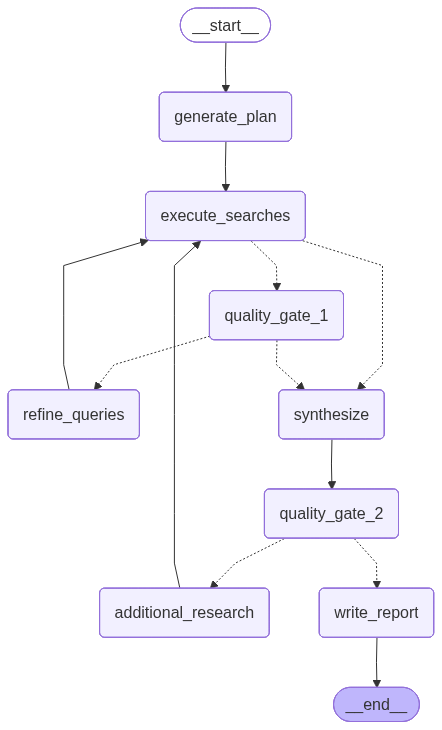

In [18]:
# Visualize the graph
from IPython.display import Image, display

try:
    display(Image(quality_gate_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

## 6. Agent Wrapper for Evaluation

In [19]:
async def quality_gates_agent_async(inputs: dict) -> dict:
    """
    Async version of the Quality Gates research agent.
    Use this version when calling from Jupyter notebooks.
    """
    question = inputs.get("question", "")

    result = await quality_gate_graph.ainvoke(
        {"question": question},
        config={"recursion_limit": 50}
    )

    return {
        "output": result.get("final_report", ""),
        "synthesis": result.get("synthesis", ""),
        "source_urls": list(set(result.get("source_urls", []))),
        "gate1_passed": result.get("gate1_passed", False),
        "gate2_passed": result.get("gate2_passed", False),
        "gate1_attempts": result.get("gate1_attempts", 0),
        "gate2_attempts": result.get("gate2_attempts", 0),
        "identified_claims": result.get("identified_claims", []),
        "weak_claims": result.get("weak_claims", [])
    }


def quality_gates_agent(inputs: dict) -> dict:
    """
    Sync wrapper function for Quality Gates research agent.

    Compatible with evaluation harness.

    Args:
        inputs: Dictionary with 'question' key

    Returns:
        Dictionary with 'output' key containing final report
    """
    question = inputs.get("question", "")

    async def _execute():
        return await quality_gate_graph.ainvoke(
            {"question": question},
            config={"recursion_limit": 50}
        )

    # Check if we're already in an async context (e.g., Jupyter notebook)
    try:
        loop = asyncio.get_running_loop()
        # We're in an event loop - need to run in a separate thread
        import concurrent.futures
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(asyncio.run, _execute())
            result = future.result()
    except RuntimeError:
        # No event loop running, safe to use asyncio.run
        result = asyncio.run(_execute())

    return {
        "output": result.get("final_report", ""),
        "synthesis": result.get("synthesis", ""),
        "source_urls": list(set(result.get("source_urls", []))),
        "gate1_passed": result.get("gate1_passed", False),
        "gate2_passed": result.get("gate2_passed", False),
        "gate1_attempts": result.get("gate1_attempts", 0),
        "gate2_attempts": result.get("gate2_attempts", 0),
        "identified_claims": result.get("identified_claims", []),
        "weak_claims": result.get("weak_claims", [])
    }

## 7. Manual Test

Run this cell to verify the agent works correctly with a simple test question.

In [20]:
# Simple test
test_question = "What are the key benefits and challenges of using large language models in enterprise applications?"

print(f"Testing Quality Gates Agent with question:\n{test_question}\n")
print("Running quality-gated research (this may take several minutes)...\n")

try:
    # Use the async version in notebooks to avoid event loop conflicts
    result = await quality_gates_agent_async({"question": test_question})

    print("\n" + "=" * 80)
    print("FINAL REPORT")
    print("=" * 80)
    print(result["output"][:3000] + "..." if len(result["output"]) > 3000 else result["output"])
    print("\n" + "=" * 80)
    print(f"Report length: {len(result['output'])} characters")
    print(f"Gate 1: {'PASSED' if result.get('gate1_passed') else 'FAILED'} (attempts: {result.get('gate1_attempts', 0)})")
    print(f"Gate 2: {'PASSED' if result.get('gate2_passed') else 'FAILED'} (attempts: {result.get('gate2_attempts', 0)})")
    print(f"Unique sources: {len(result.get('source_urls', []))}")
    print(f"Claims identified: {len(result.get('identified_claims', []))}")
    print(f"Weak claims remaining: {len(result.get('weak_claims', []))}")
    print("Agent test PASSED")
except Exception as e:
    print(f"Agent test FAILED: {e}")
    import traceback
    traceback.print_exc()
    raise

Testing Quality Gates Agent with question:
What are the key benefits and challenges of using large language models in enterprise applications?

Running quality-gated research (this may take several minutes)...

Generated 7 search queries

Executing 7 searches...
  [1/7] Large language models definition transformer pretraining fin...
  [2/7] LLM enterprise adoption statistics 2023 2024 market size ROI...
  [3/7] LLM challenges in enterprise hallucinations privacy data lea...
  [4/7] Enterprise LLM case studies customer support knowledge manag...
  [5/7] Expert opinions LLMs in enterprise Gartner McKinsey Forreste...
  [6/7] Enterprise LLM architectures RAG vector database retrieval-a...
  [7/7] Legal and regulatory considerations for enterprise LLMs GDPR...
  Collected 60 results from 53 unique URLs

--- Quality Gate 1 (Attempt 1/4) ---
  Unique sources: 53 (min: 5)
  Unique domains: 50 (min: 3)
  ✓ Gate 1 PASSED

  Using 22/60 results for synthesis (11815 chars)
  Synthesis complete: 6

## 8. Evaluation Harness Integration

Once the manual test passes, uncomment and run the cells below for full evaluation.

In [ ]:
# Import evaluation harness and metrics
import sys
sys.path.insert(0, "..")
from evaluation import (
    ExperimentHarness, 
    fact_recall, 
    citation_precision,
    coherence_judge, 
    depth_judge, 
    relevance_judge,
    minimum_sources_check
)

# Initialize harness with the golden test dataset
harness = ExperimentHarness(
    dataset_path="../data/deep_research_agent_test_dataset.yaml",
    langsmith_dataset_name="deep-research-golden-v2"
)

print("Evaluation harness initialized successfully!")
print(f"Dataset: {harness.dataset_path}")
print(f"LangSmith dataset name: {harness.langsmith_dataset_name}")

In [ ]:
# Full Evaluation on All 20 Questions
# ⚠️ EXPENSIVE - Only uncomment when ready for full evaluation
# Uncomment to run:

# # Define comprehensive evaluator suite
# evaluators = [
#     fact_recall,              # Required facts coverage
#     citation_precision,       # Citation URL validity
#     minimum_sources_check,    # Minimum source count
#     coherence_judge,          # Logical structure
#     depth_judge,              # Analysis depth
#     relevance_judge,          # Addresses question
# ]
# 
# # Run full evaluation
# print("Starting FULL evaluation on all 20 questions...")
# print("Quality Gates Agent - this will take 1-2 hours.")
# print("=" * 80 + "\n")
# 
# results = harness.run_evaluation(
#     agent_fn=quality_gates_agent,
#     evaluators=evaluators,
#     experiment_name="quality_gates_v1",
#     monte_carlo_runs=1,  # Single run to reduce cost
#     max_concurrency=2,   # Lower concurrency for stability
#     description="Quality Gates paradigm evaluation on all difficulty tiers"
# )
# 
# # Display comprehensive results
# print("\n" + "=" * 80)
# print("FULL EVALUATION RESULTS")
# print("=" * 80)
# print(f"Experiment: {results.experiment_name}")
# print(f"Questions evaluated: {results.num_questions}")
# print(f"Runs per question: {results.num_runs}")
# 
# print(f"\n{'Metric':<30} {'Mean':<10}")
# print("-" * 40)
# for metric_name in sorted(results.metrics.keys()):
#     if not metric_name.endswith('_std'):
#         value = results.metrics.get(metric_name, 0)
#         print(f"{metric_name:<30} {value:<10.3f}")
# 
# # Save results to file
# import json
# from datetime import datetime
# 
# results_file = Path("../results") / f"quality_gates_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
# results_file.parent.mkdir(exist_ok=True)
# 
# with open(results_file, 'w') as f:
#     json.dump({
#         "experiment_name": results.experiment_name,
#         "num_questions": results.num_questions,
#         "num_runs": results.num_runs,
#         "metrics": results.metrics,
#         "per_question": results.per_question_results
#     }, f, indent=2)
# 
# print(f"\nResults saved to: {results_file}")

print("Full evaluation cell ready. Uncomment to run when ready.")